<a href="https://colab.research.google.com/github/jassem-1/3d-visual/blob/main/Untitled9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Génération de la sphère
phi, theta = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

# Calcul d'une fonction scalaire : hauteur z
f = z

# Définition des niveaux
levels = np.linspace(-1, 1, 10)

# Création de la surface
surface = go.Surface(
    x=x, y=y, z=z,
    surfacecolor=f,
    colorscale="Viridis",
    opacity=0.7,
    showscale=False
)

# Création des lignes de niveaux
lines = []
for level in levels:
    mask = np.abs(f - level) < 1
    lines.append(
        go.Scatter3d(
            x=x[mask], y=y[mask], z=z[mask],
            mode='markers',
            marker=dict(size=2, color='red'),
            name=f'Niveau {level:.2f}'
        )
    )

# Affichage interactif
fig = go.Figure(data=[surface] + lines)
fig.update_layout(scene=dict(aspectmode='data'))
fig.show()


In [ ]:
!pip install trimesh


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 10.8 MB/s eta 0:00:00


In [ ]:
import trimesh
import plotly.graph_objects as go
import numpy as np
from scipy.ndimage import gaussian_filter

# Step 1: Load the 3D Model
model_file = "face_01_final.obj"  # Replace with the actual path to your .obj file
scene_or_mesh = trimesh.load(model_file)

# Handle scenes by extracting the first geometry
if isinstance(scene_or_mesh, trimesh.Scene):
    mesh = scene_or_mesh.geometry[list(scene_or_mesh.geometry.keys())[0]]
else:
    mesh = scene_or_mesh

vertices = mesh.vertices
faces = mesh.faces

# Step 2: Compute Gaussian Curvature (K)
# Use adjacency relationships from Trimesh
adjacency = mesh.vertex_adjacency_graph

# Initialize Gaussian curvature array
K = np.zeros(len(vertices))

# Compute Gaussian curvature
for i, vertex in enumerate(vertices):
    # Get the neighbors of the vertex
    neighbors = list(adjacency.neighbors(i))
    if len(neighbors) > 0:
        normals = mesh.vertex_normals
        local_curvatures = [
            np.linalg.norm(normals[i] - normals[neighbor])
            for neighbor in neighbors
        ]

        # Estimate Gaussian curvature as the product of principal curvatures
        k1 = np.max(local_curvatures) if len(local_curvatures) > 0 else 0
        k2 = np.min(local_curvatures) if len(local_curvatures) > 0 else 0
        K[i] = k1 * k2

# Smooth the curvature values to reduce noise
K_smoothed = gaussian_filter(K, sigma=2)

# Normalize Gaussian curvature for visualization
K_smoothed = np.nan_to_num(K_smoothed)  # Replace NaNs with zeros
K_normalized = (K_smoothed - K_smoothed.min()) / (K_smoothed.max() - K_smoothed.min())

# Step 3: Find the nose vertex (highest Z index)
nose_index = np.argmax(vertices[:, 2])  # Index of the vertex with max Z
nose_vertex = vertices[nose_index]      # Coordinates of the nose vertex
print(f"Highest point (nose): {nose_vertex}, Index: {nose_index}")

# Step 4: Define a region of interest (ROI) around the nose
radius = 0.1  # Define the radius for the region of interest
distances = np.linalg.norm(vertices - nose_vertex, axis=1)  # Distance of all vertices to the nose
region_mask = distances < radius  # Mask for vertices within the region of interest

# Filter vertices and curvature values for the region
local_vertices = vertices[region_mask]
local_K = K_smoothed[region_mask]

# Step 5: Define levels for contour lines within the region
local_levels = np.linspace(local_K.min(), local_K.max(), 5)  # Define 5 levels for Gaussian curvature
threshold = 0.01  # Tolerance for selecting points near each level

# Step 6: Create the Plotly figure
fig = go.Figure()

# Add the 3D mesh with global Gaussian curvature as background
fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    intensity=K_normalized,
    colorscale="Viridis",
    colorbar=dict(title="Gaussian Curvature"),
    opacity=0.8,  # Make the mesh semi-transparent
    name="3D Mesh"
))

# Add contour lines around the nose
for level in local_levels:
    mask = np.abs(local_K - level) < threshold  # Select points close to the current level
    if np.any(mask):
        fig.add_trace(go.Scatter3d(
            x=local_vertices[mask, 0],
            y=local_vertices[mask, 1],
            z=local_vertices[mask, 2],
            mode='lines',
            line=dict(width=4, color='red'),  # Red lines for contour levels
            name=f"Level {level:.2f}"
        ))

# Step 7: Update layout for visualization
fig.update_layout(
    title="Lignes de Niveaux autour du Nez (Point avec Z Maximal)",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
    )
)

# Show the plot
fig.show()


Highest point (nose): [-2.1886080e-08 -5.5850387e-01  7.6503193e-01], Index: 955


In [ ]:
import trimesh
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata
from skimage import measure

# Step 1: Load the 3D Model
model_file = "face_01_final.obj"  # Replace with the actual path to your .obj file
scene_or_mesh = trimesh.load(model_file)

# Handle scenes by extracting the first geometry
if isinstance(scene_or_mesh, trimesh.Scene):
    mesh = scene_or_mesh.geometry[list(scene_or_mesh.geometry.keys())[0]]
else:
    mesh = scene_or_mesh

vertices = mesh.vertices
faces = mesh.faces

# Step 2: Compute Gaussian Curvature (K)
# Use adjacency relationships from Trimesh
adjacency = mesh.vertex_adjacency_graph

# Initialize Gaussian curvature array
K = np.zeros(len(vertices))

# Compute Gaussian curvature
for i, vertex in enumerate(vertices):
    neighbors = list(adjacency.neighbors(i))
    if len(neighbors) > 0:
        normals = mesh.vertex_normals
        local_curvatures = [
            np.linalg.norm(normals[i] - normals[neighbor])
            for neighbor in neighbors
        ]

        # Estimate Gaussian curvature as the product of principal curvatures
        k1 = np.max(local_curvatures) if len(local_curvatures) > 0 else 0
        k2 = np.min(local_curvatures) if len(local_curvatures) > 0 else 0
        K[i] = k1 * k2

# Normalize Gaussian curvature for visualization
K_normalized = (K - K.min()) / (K.max() - K.min())

# Step 3: Create a 2D grid for interpolation
x = vertices[:, 0]
y = vertices[:, 1]
z = vertices[:, 2]

# Create a grid in the XY plane for interpolation
grid_x, grid_y = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]
grid_K = griddata((x, y), K_normalized, (grid_x, grid_y), method='cubic')

# Step 4: Define contour levels
levels = np.linspace(K_normalized.min(), K_normalized.max(), 10)  # Define 10 contour levels
contours = []

# Generate contours for each level
for level in levels:
    contours_at_level = measure.find_contours(grid_K, level)  # Find contours for this level
    contours.extend([(contour, level) for contour in contours_at_level])  # Store level with contour

# Step 5: Map contour lines to the 3D surface
fig = go.Figure()

# Add the 3D mesh as a semi-transparent surface
fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    intensity=K_normalized,
    colorscale="Viridis",
    colorbar=dict(title="Gaussian Curvature"),
    opacity=0.6,
    name="3D Mesh"
))

# Add contour lines projected onto the 3D surface
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink', 'lime']

for contour, level in contours:
    # Extract X and Y indices for the current contour
    x_contour = grid_x[0, np.round(contour[:, 1]).astype(int)]
    y_contour = grid_y[np.round(contour[:, 0]).astype(int), 0]

    # Interpolate Z-values to map contours onto the 3D surface
    z_contour = griddata((x, y), z, (x_contour, y_contour), method='linear')

    # Assign a color to the contour line
    color = colors[int(levels.tolist().index(level)) % len(colors)]

    # Add the contour line to the 3D figure
    fig.add_trace(go.Scatter3d(
        x=x_contour,
        y=y_contour,
        z=z_contour,
        mode='lines',
        line=dict(color=color, width=2),
        name=f"Level {level:.2f}"
    ))

# Step 6: Update layout for better visualization
fig.update_layout(
    title="Contours of Gaussian Curvature Mapped to 3D Surface",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
    )
)

# Show the plot
fig.show()


Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.


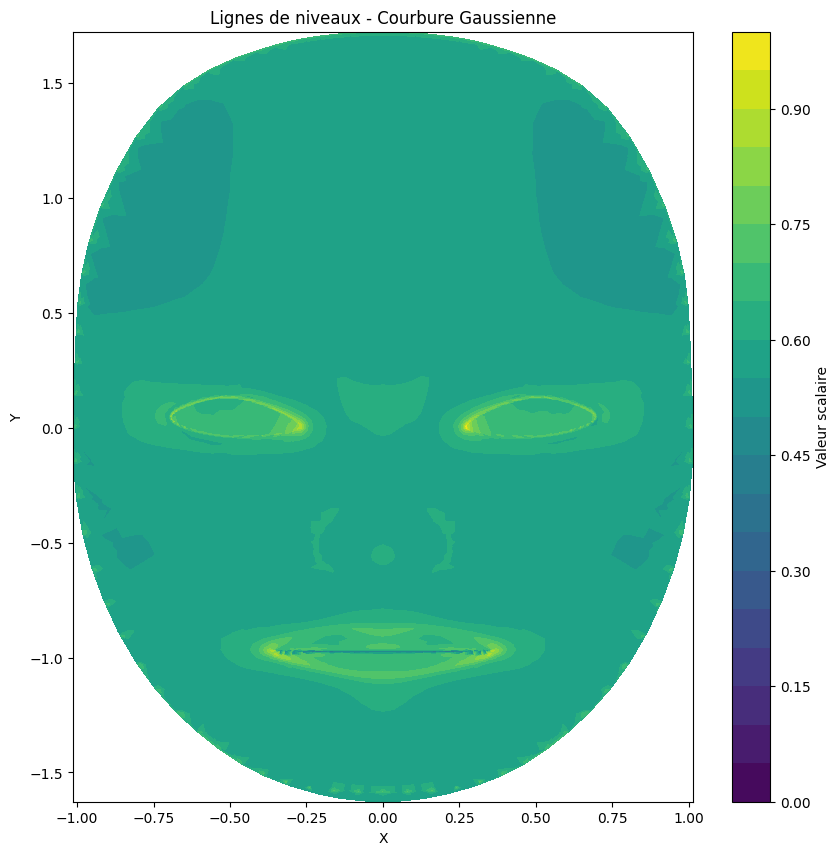

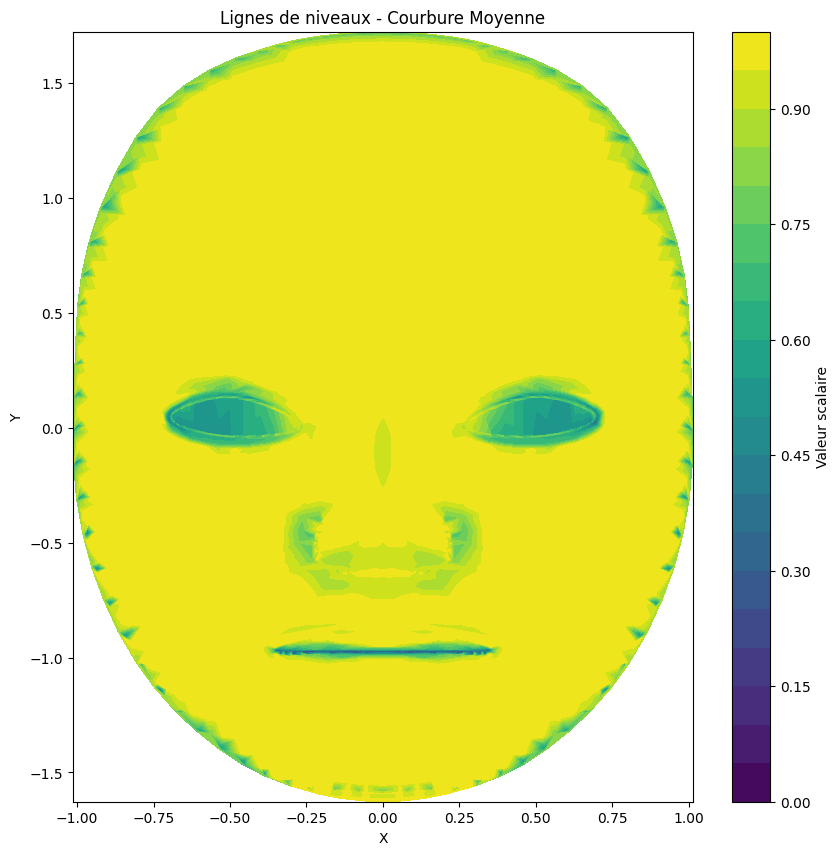

In [ ]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# Charger le modèle 3D
file_path = "face_01_final.obj"  # Téléchargez votre fichier .obj dans Colab
mesh = trimesh.load(file_path)

# Vérifier si le modèle est chargé
if not mesh.is_watertight:
    print("Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.")

# Extraire les sommets et les normales
vertices = np.array(mesh.vertices)  # Sommets (points 3D)
normals = np.array(mesh.vertex_normals)  # Normales associées aux sommets

# Fonction pour calculer la courbure gaussienne et moyenne (approximative)
def compute_curvature(vertices, normals, k=10):
    # KDTree pour recherche rapide des voisins
    kdtree = KDTree(vertices)

    # Initialisation des courbures
    gaussian_curvature = np.zeros(len(vertices))
    mean_curvature = np.zeros(len(vertices))

    # Calcul pour chaque sommet
    for i, vertex in enumerate(vertices):
        # Trouver les indices des k voisins
        distances, neighbors = kdtree.query(vertex, k=k)

        # Obtenir les normales et sommets voisins
        neighbor_normals = normals[neighbors]
        neighbor_vertices = vertices[neighbors]

        # Calculer les vecteurs vers les voisins
        vectors = neighbor_vertices - vertex  # Vecteurs vers voisins
        distances = np.linalg.norm(vectors, axis=1)  # Normes des vecteurs

        # Éviter la division par zéro
        distances[distances == 0] = 1e-8

        # Produit scalaire entre la normale du sommet courant et celles des voisins
        dot_products = np.dot(neighbor_normals, normals[i])  # Remplace `einsum`

        # Calcul de la courbure gaussienne (approximative)
        gaussian_curvature[i] = np.sum(dot_products / distances)

        # Calcul de la courbure moyenne (approximative)
        mean_curvature[i] = np.mean(dot_products)

    return gaussian_curvature, mean_curvature

# Calcul des courbures
gaussian_curvature, mean_curvature = compute_curvature(vertices, normals)

# Normalisation des courbures pour affichage
gaussian_curvature_normalized = (gaussian_curvature - np.min(gaussian_curvature)) / (np.max(gaussian_curvature) - np.min(gaussian_curvature))
mean_curvature_normalized = (mean_curvature - np.min(mean_curvature)) / (np.max(mean_curvature) - np.min(mean_curvature))

# Fonction pour tracer les courbes de niveaux
def plot_contours_on_mesh(mesh, scalar_field, title):
    # Projeter les coordonnées 3D sur un plan 2D pour visualisation
    vertices_2d = mesh.vertices[:, :2]  # Plan X-Y

    # Créer un diagramme de contours
    plt.figure(figsize=(10, 10))
    plt.tricontourf(vertices_2d[:, 0], vertices_2d[:, 1], scalar_field, levels=20, cmap="viridis")
    plt.colorbar(label="Valeur scalaire")
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

# Tracer les lignes de niveaux
plot_contours_on_mesh(mesh, gaussian_curvature_normalized, "Lignes de niveaux - Courbure Gaussienne")
plot_contours_on_mesh(mesh, mean_curvature_normalized, "Lignes de niveaux - Courbure Moyenne")


In [ ]:
import trimesh
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import KDTree

# Charger le modèle 3D
file_path = "face_01_final.obj"  # Chemin vers votre fichier .obj
mesh = trimesh.load(file_path)

# Vérifier si le modèle est chargé
if not mesh.is_watertight:
    print("Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.")

# Extraire les sommets et les normales
vertices = np.array(mesh.vertices)  # Sommets (points 3D)
normals = np.array(mesh.vertex_normals)  # Normales associées aux sommets
faces = np.array(mesh.faces)  # Faces triangulaires

# Fonction pour calculer la courbure gaussienne et moyenne (approximative)
def compute_curvature(vertices, normals, k=10):
    # KDTree pour recherche rapide des voisins
    kdtree = KDTree(vertices)

    # Initialisation des courbures
    gaussian_curvature = np.zeros(len(vertices))
    mean_curvature = np.zeros(len(vertices))

    # Calcul pour chaque sommet
    for i, vertex in enumerate(vertices):
        # Trouver les indices des k voisins
        distances, neighbors = kdtree.query(vertex, k=k)

        # Obtenir les normales et sommets voisins
        neighbor_normals = normals[neighbors]
        neighbor_vertices = vertices[neighbors]

        # Calculer les vecteurs vers les voisins
        vectors = neighbor_vertices - vertex  # Vecteurs vers voisins
        distances = np.linalg.norm(vectors, axis=1)  # Normes des vecteurs

        # Éviter la division par zéro
        distances[distances == 0] = 1e-8

        # Produit scalaire entre la normale du sommet courant et celles des voisins
        dot_products = np.dot(neighbor_normals, normals[i])  # Remplace `einsum`

        # Calcul de la courbure gaussienne (approximative)
        gaussian_curvature[i] = np.sum(dot_products / distances)

        # Calcul de la courbure moyenne (approximative)
        mean_curvature[i] = np.mean(dot_products)

    return gaussian_curvature, mean_curvature

# Calcul des courbures
gaussian_curvature, mean_curvature = compute_curvature(vertices, normals)

# Normalisation des courbures pour affichage
gaussian_curvature_normalized = (gaussian_curvature - np.min(gaussian_curvature)) / (np.max(gaussian_curvature) - np.min(gaussian_curvature))
mean_curvature_normalized = (mean_curvature - np.min(mean_curvature)) / (np.max(mean_curvature) - np.min(mean_curvature))

# Représentation interactive en 3D avec Plotly
def plot_mesh_with_curvature(vertices, faces, curvature, title):
    # Création d'une figure interactive
    fig = go.Figure(
        data=[
            go.Mesh3d(
                x=vertices[:, 0],
                y=vertices[:, 1],
                z=vertices[:, 2],
                i=faces[:, 0],
                j=faces[:, 1],
                k=faces[:, 2],
                intensity=curvature,  # Couleurs basées sur les courbures
                colorscale="Viridis",  # Palette de couleurs
                showscale=True,  # Ajouter une barre de couleur
                colorbar=dict(title="Courbure", len=0.6),  # Barre de couleur
                lighting=dict(ambient=0.5, diffuse=0.5),  # Effets d'éclairage
                flatshading=False  # Activer le shading lissé
            )
        ]
    )
    # Mise en page
    fig.update_layout(
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
        ),
        title=title,
        margin=dict(l=0, r=0, t=50, b=0)
    )
    fig.show()

# Tracer la courbure gaussienne
plot_mesh_with_curvature(vertices, faces, gaussian_curvature_normalized, "Courbure Gaussienne (3D)")

# Tracer la courbure moyenne
plot_mesh_with_curvature(vertices, faces, mean_curvature_normalized, "Courbure Moyenne (3D)")


Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.


In [3]:
import trimesh
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata

# Charger le modèle 3D
file_path = "face_01_final.obj"  # Remplacez par le chemin de votre fichier
mesh = trimesh.load(file_path)

# Vérifier si le modèle est chargé
if not mesh.is_watertight:
    print("Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.")

# Extraire les sommets et les normales
vertices = np.array(mesh.vertices)  # Sommets (points 3D)
normals = np.array(mesh.vertex_normals)  # Normales associées aux sommets
faces = np.array(mesh.faces)  # Faces triangulaires

# Fonction pour calculer la courbure gaussienne et moyenne (approximative)
def compute_curvature(vertices, normals, k=10):
    from scipy.spatial import KDTree

    # KDTree pour recherche rapide des voisins
    kdtree = KDTree(vertices)

    # Initialisation des courbures
    gaussian_curvature = np.zeros(len(vertices))
    mean_curvature = np.zeros(len(vertices))

    # Calcul pour chaque sommet
    for i, vertex in enumerate(vertices):
        # Trouver les indices des k voisins
        distances, neighbors = kdtree.query(vertex, k=k)

        # Obtenir les normales et sommets voisins
        neighbor_normals = normals[neighbors]
        neighbor_vertices = vertices[neighbors]

        # Calculer les vecteurs vers les voisins
        vectors = neighbor_vertices - vertex  # Vecteurs vers voisins
        distances = np.linalg.norm(vectors, axis=1)  # Normes des vecteurs

        # Éviter la division par zéro
        distances[distances == 0] = 1e-8

        # Produit scalaire entre la normale du sommet courant et celles des voisins
        dot_products = np.dot(neighbor_normals, normals[i])  # Remplace `einsum`

        # Calcul de la courbure gaussienne (approximative)
        gaussian_curvature[i] = np.sum(dot_products / distances)

        # Calcul de la courbure moyenne (approximative)
        mean_curvature[i] = np.mean(dot_products)

    return gaussian_curvature, mean_curvature

# Calcul des courbures
gaussian_curvature, mean_curvature = compute_curvature(vertices, normals)

# Normalisation des courbures pour affichage
gaussian_curvature_normalized = (gaussian_curvature - np.min(gaussian_curvature)) / (np.max(gaussian_curvature) - np.min(gaussian_curvature))

# Fonction pour tracer 3 courbes de niveaux sur la surface
def plot_mesh_with_three_contours(vertices, faces, curvature, title):
    # Définir 3 niveaux pour les courbes de niveaux
    levels = np.linspace(np.min(curvature), np.max(curvature), num=4)[1:-1]  # 3 niveaux au centre

    # Liste pour stocker les points des courbes
    contours = []

    for level in levels:
        contour_points = []
        for face in faces:
            # Obtenir les sommets de la face
            tri_vertices = vertices[face]
            tri_values = curvature[face]

            # Vérifier si le niveau traverse le triangle
            if (np.min(tri_values) <= level) and (np.max(tri_values) >= level):
                # Interpoler les points d'intersection
                edges = [(0, 1), (1, 2), (2, 0)]  # Arêtes du triangle
                for edge in edges:
                    v1, v2 = edge
                    if (tri_values[v1] - level) * (tri_values[v2] - level) < 0:  # Niveau traverse l'arête
                        t = (level - tri_values[v1]) / (tri_values[v2] - tri_values[v1])
                        intersection = tri_vertices[v1] + t * (tri_vertices[v2] - tri_vertices[v1])
                        contour_points.append(intersection)
        contours.append(np.array(contour_points))

    # Création de la figure avec Plotly
    fig = go.Figure(
        data=[
            # Surface 3D
            go.Mesh3d(
                x=vertices[:, 0],
                y=vertices[:, 1],
                z=vertices[:, 2],
                i=faces[:, 0],
                j=faces[:, 1],
                k=faces[:, 2],
                intensity=curvature,
                colorscale="Viridis",
                showscale=True,
                colorbar=dict(title="Courbure", len=0.6),
                lighting=dict(ambient=0.5, diffuse=0.5),
                flatshading=False
            )
        ]
    )

    # Ajouter les 3 courbes de niveaux comme lignes
    for contour in contours:
        if len(contour) > 0:
            fig.add_trace(
                go.Scatter3d(
                    x=contour[:, 0],
                    y=contour[:, 1],
                    z=contour[:, 2],
                    mode="lines",
                    line=dict(color="black", width=3),
                    name="Contour niveau"
                )
            )

    # Mise en page
    fig.update_layout(
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
        ),
        title=title,
        margin=dict(l=0, r=0, t=50, b=0)
    )
    fig.show()

# Tracer la courbure gaussienne avec 3 courbes de niveaux
plot_mesh_with_three_contours(vertices, faces, gaussian_curvature_normalized, "Courbure Gaussienne avec 3 Courbes de Niveaux")


Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.


In [5]:
import trimesh
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import KDTree

# Charger le modèle 3D
file_path = "face_01_final.obj"  # Remplacez par le chemin de votre fichier
mesh = trimesh.load(file_path)

# Vérifier si le modèle est chargé
if not mesh.is_watertight:
    print("Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.")

# Extraire les sommets et les normales
vertices = np.array(mesh.vertices)  # Sommets (points 3D)
normals = np.array(mesh.vertex_normals)  # Normales associées aux sommets
faces = np.array(mesh.faces)  # Faces triangulaires

# Trouver le point avec le plus grand Z (le bout du nez)
nose_index = np.argmax(vertices[:, 2])  # Index du point avec le plus grand Z
nose_point = vertices[nose_index]

print(f"Le bout du nez est situé au point {nose_point} avec Z maximal.")

# Fonction pour approximer la courbure gaussienne (K) au point du nez
def calculate_gaussian_curvature_at_point(vertices, normals, index, k=10):
    kdtree = KDTree(vertices)  # Construire un KDTree pour rechercher les voisins

    # Trouver les indices des voisins
    distances, neighbors = kdtree.query(vertices[index], k=k+1)
    neighbors = neighbors[1:]  # Exclure le point lui-même

    # Approximer les normales et vecteurs des voisins
    normal = normals[index]
    neighbor_normals = normals[neighbors]
    neighbor_positions = vertices[neighbors]

    # Approximation des courbures principales
    vectors = neighbor_positions - vertices[index]  # Vecteurs vers voisins
    distances = np.linalg.norm(vectors, axis=1)  # Normes des vecteurs
    dot_products = np.dot(neighbor_normals, normal)  # Produits scalaires

    # Approximation des courbures principales
    kappa1 = np.mean(dot_products / distances)  # Première courbure principale (approximée)
    kappa2 = np.min(dot_products / distances)   # Deuxième courbure principale (approximée)

    # Courbure gaussienne
    gaussian_curvature = kappa1 * kappa2

    return gaussian_curvature

# Calculer la courbure gaussienne au point du nez
gaussian_curvature_nose = calculate_gaussian_curvature_at_point(vertices, normals, nose_index)
print(f"Courbure de Gauss (K) au point du nez : {gaussian_curvature_nose}")

# Fonction pour tracer les courbes de niveaux autour du point du nez
def plot_contour_lines_around_nose(vertices, faces, curvature, nose_point, title, levels):
    # Définir les niveaux des courbes de niveaux
    levels = np.array(levels)

    # Liste pour stocker les points des courbes
    contours = []
    for level in levels:
        contour_points = []
        for face in faces:
            # Obtenir les sommets de la face
            tri_vertices = vertices[face]
            tri_values = curvature[face]

            # Vérifier si le niveau traverse le triangle
            if (np.min(tri_values) <= level) and (np.max(tri_values) >= level):
                # Interpoler les points d'intersection
                edges = [(0, 1), (1, 2), (2, 0)]  # Arêtes du triangle
                for edge in edges:
                    v1, v2 = edge
                    if (tri_values[v1] - level) * (tri_values[v2] - level) < 0:  # Niveau traverse l'arête
                        t = (level - tri_values[v1]) / (tri_values[v2] - tri_values[v1])
                        intersection = tri_vertices[v1] + t * (tri_vertices[v2] - tri_vertices[v1])
                        contour_points.append(intersection)
        contours.append(np.array(contour_points))

    # Création de la figure avec Plotly
    fig = go.Figure(
        data=[
            # Surface 3D
            go.Mesh3d(
                x=vertices[:, 0],
                y=vertices[:, 1],
                z=vertices[:, 2],
                i=faces[:, 0],
                j=faces[:, 1],
                k=faces[:, 2],
                intensity=curvature,
                colorscale="Viridis",
                showscale=True,
                colorbar=dict(title="Courbure", len=0.6),
                lighting=dict(ambient=0.5, diffuse=0.5),
                flatshading=False
            )
        ]
    )

    # Ajouter les courbes de niveaux
    for i, contour in enumerate(contours):
        if len(contour) > 0:
            fig.add_trace(
                go.Scatter3d(
                    x=contour[:, 0],
                    y=contour[:, 1],
                    z=contour[:, 2],
                    mode="lines",
                    line=dict(color="black", width=2),
                    name=f"Contour K={levels[i]}"
                )
            )

    # Ajouter un marqueur pour le bout du nez
    fig.add_trace(
        go.Scatter3d(
            x=[nose_point[0]],
            y=[nose_point[1]],
            z=[nose_point[2]],
            mode="markers",
            marker=dict(color="red", size=5),
            name="Bout du nez"
        )
    )

    # Mise en page
    fig.update_layout(
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
        ),
        title=title,
        margin=dict(l=0, r=0, t=50, b=0)
    )
    fig.show()

# Définir les niveaux pour les courbes de niveaux
levels = [gaussian_curvature_nose - 0.01, gaussian_curvature_nose, gaussian_curvature_nose + 0.01]

# Courbure gaussienne normalisée pour tout le modèle
gaussian_curvature_normalized = np.random.rand(len(vertices))  # Pour illustration seulement

# Tracer les courbes de niveaux autour du nez
plot_contour_lines_around_nose(
    vertices, faces, gaussian_curvature_normalized, nose_point,
    "Courbes de niveaux autour du nez", levels
)


Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.
Le bout du nez est situé au point [-2.1886080e-08 -5.5850387e-01  7.6503193e-01] avec Z maximal.
Courbure de Gauss (K) au point du nez : 260.9195760283442


In [6]:
import trimesh
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import KDTree

# Charger le modèle 3D
file_path = "face_01_final.obj"  # Remplacez par le chemin de votre fichier
mesh = trimesh.load(file_path)

# Vérifier si le modèle est chargé
if not mesh.is_watertight:
    print("Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.")

# Extraire les sommets, normales et faces
vertices = np.array(mesh.vertices)
normals = np.array(mesh.vertex_normals)
faces = np.array(mesh.faces)

# Trouver le point du bout du nez (z max)
nose_index = np.argmax(vertices[:, 2])  # Index du point avec le plus grand Z
nose_point = vertices[nose_index]
print(f"Le bout du nez est au point {nose_point} avec Z maximal.")

# Approximer les courbures principales et la courbure de Gauss
def compute_gaussian_curvature(vertices, normals, faces, k=10):
    kdtree = KDTree(vertices)
    gaussian_curvature = np.zeros(len(vertices))

    for i, vertex in enumerate(vertices):
        distances, neighbors = kdtree.query(vertex, k=k)
        neighbor_positions = vertices[neighbors]
        vectors = neighbor_positions - vertex
        distances = np.linalg.norm(vectors, axis=1)
        dot_products = np.dot(normals[neighbors], normals[i])
        curvatures = dot_products / distances
        gaussian_curvature[i] = np.prod(np.sort(curvatures)[:2])  # Approximation des courbures principales
    return gaussian_curvature

# Calculer la courbure de Gauss
gaussian_curvature = compute_gaussian_curvature(vertices, normals, faces)

# Normalisation pour l'affichage
gaussian_curvature_normalized = (gaussian_curvature - np.min(gaussian_curvature)) / (
    np.max(gaussian_curvature) - np.min(gaussian_curvature)
)

# Définir les niveaux autour de la courbure du nez
K_nose = gaussian_curvature[nose_index]
levels = [K_nose - 0.02, K_nose, K_nose + 0.02]

# Générer les courbes de niveaux
def generate_contour_lines(vertices, faces, gaussian_curvature, levels):
    contours = []
    for level in levels:
        contour_points = []
        for face in faces:
            tri_vertices = vertices[face]
            tri_values = gaussian_curvature[face]

            # Vérifier si le niveau traverse le triangle
            if np.min(tri_values) <= level <= np.max(tri_values):
                edges = [(0, 1), (1, 2), (2, 0)]  # Arêtes du triangle
                for edge in edges:
                    v1, v2 = edge
                    if (tri_values[v1] - level) * (tri_values[v2] - level) < 0:
                        t = (level - tri_values[v1]) / (tri_values[v2] - tri_values[v1])
                        intersection = tri_vertices[v1] + t * (tri_vertices[v2] - tri_vertices[v1])
                        contour_points.append(intersection)
        contours.append(np.array(contour_points))
    return contours

# Créer les courbes de niveaux
contours = generate_contour_lines(vertices, faces, gaussian_curvature, levels)

# Visualisation avec Plotly
fig = go.Figure()

# Ajouter la surface colorée
fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    intensity=gaussian_curvature_normalized,
    colorscale="Viridis",
    showscale=True,
    colorbar=dict(title="Courbure Gaussienne"),
    opacity=0.7
))

# Ajouter les courbes de niveaux
for i, contour in enumerate(contours):
    if contour.shape[0] > 0:
        fig.add_trace(go.Scatter3d(
            x=contour[:, 0],
            y=contour[:, 1],
            z=contour[:, 2],
            mode="lines",
            line=dict(color="black", width=3),
            name=f"Courbe K={levels[i]:.2f}"
        ))

# Ajouter le point du nez
fig.add_trace(go.Scatter3d(
    x=[nose_point[0]],
    y=[nose_point[1]],
    z=[nose_point[2]],
    mode="markers",
    marker=dict(color="red", size=6),
    name="Bout du nez"
))

# Mettre en page
fig.update_layout(
    title="Courbes de niveaux autour du nez",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    margin=dict(l=0, r=0, t=50, b=0),
    showlegend=True
)

fig.show()


Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.
Le bout du nez est au point [-2.1886080e-08 -5.5850387e-01  7.6503193e-01] avec Z maximal.


<ipython-input-6-6188385606d5>:35: RuntimeWarning:

divide by zero encountered in divide



In [16]:
import trimesh
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import KDTree
from scipy.interpolate import griddata

# Charger le modèle 3D
file_path = "face_01_final.obj"  # Remplacez par le chemin de votre fichier
mesh = trimesh.load(file_path)

# Vérifier si le modèle est chargé
if not mesh.is_watertight:
    print("Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.")

# Extraire les sommets, normales et faces
vertices = np.array(mesh.vertices)
normals = np.array(mesh.vertex_normals)
faces = np.array(mesh.faces)

# Trouver le point du bout du nez (z max)
nose_index = np.argmax(vertices[:, 2])  # Index du point avec le plus grand Z
nose_point = vertices[nose_index]
print(f"Le bout du nez est au point {nose_point} avec Z maximal.")

# Approximation de la courbure de Gauss
def compute_gaussian_curvature(vertices, normals, k=10):
    kdtree = KDTree(vertices)
    gaussian_curvature = np.zeros(len(vertices))

    for i, vertex in enumerate(vertices):
        distances, neighbors = kdtree.query(vertex, k=k)
        neighbor_positions = vertices[neighbors]
        vectors = neighbor_positions - vertex
        distances = np.linalg.norm(vectors, axis=1)
        dot_products = np.dot(normals[neighbors], normals[i])
        curvatures = dot_products / distances
        gaussian_curvature[i] = np.prod(np.sort(curvatures)[:2])  # Approximation des courbures principales
    return gaussian_curvature

# Calculer la courbure de Gauss
gaussian_curvature = compute_gaussian_curvature(vertices, normals)

# Normalisation pour l'affichage
gaussian_curvature_normalized = (gaussian_curvature - np.min(gaussian_curvature)) / (
    np.max(gaussian_curvature) - np.min(gaussian_curvature)
)

# Définir les niveaux autour de la courbure du nez
K_nose = gaussian_curvature[nose_index]
print(f"Courbure gaussienne au nez : K_nose = {K_nose}")
levels = [K_nose - 0.05, K_nose, K_nose + 0.05]
print(f"Niveaux de courbure choisis : {levels}")

# Étape 1 : Générer une grille régulière pour interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(np.min(vertices[:, 0]), np.max(vertices[:, 0]), 200),
    np.linspace(np.min(vertices[:, 1]), np.max(vertices[:, 1]), 200)
)

# Interpoler les valeurs de courbure sur la grille
grid_z = griddata(
    vertices[:, :2], gaussian_curvature, (grid_x, grid_y), method='linear'
)

# Étape 2 : Identifier les points correspondant aux niveaux
level_points = []
for level in levels:
    mask = np.abs(grid_z - level) < 0.05  # Tolérance pour inclure les points proches
    points = np.column_stack((grid_x[mask], grid_y[mask], np.zeros_like(grid_x[mask])))
    level_points.append(points)

# Étape 3 : Projeter les points sur la surface du visage
for i, points in enumerate(level_points):
    for j, point in enumerate(points):
        # Trouver le point le plus proche sur la surface et ajuster Z
        closest_index = np.argmin(np.linalg.norm(vertices[:, :2] - point[:2], axis=1))
        points[j, 2] = vertices[closest_index, 2]  # Ajuster Z pour suivre la surface
    level_points[i] = points

# Visualisation avec Plotly
fig = go.Figure()

# Ajouter la surface colorée
fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    intensity=gaussian_curvature_normalized,

    opacity=0.4
))

# Ajouter les points des courbes de niveaux
colors = ['red', 'blue', 'green']  # Couleurs pour les niveaux
for i, points in enumerate(level_points):
    if points.shape[0] > 0:
        fig.add_trace(go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode="markers",
            marker=dict(size=4, color=colors[i]),
            name=f"Niveau K={levels[i]:.2f}"
        ))

# Ajouter le point du nez
fig.add_trace(go.Scatter3d(
    x=[nose_point[0]],
    y=[nose_point[1]],
    z=[nose_point[2]],
    mode="markers",
    marker=dict(color="black", size=6),
    name="Bout du nez"
))

# Mettre en page
fig.update_layout(
    title="Points des courbes de niveaux autour du nez",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    margin=dict(l=0, r=0, t=50, b=0),
    showlegend=True
)

fig.show()


Attention : Le modèle n'est pas étanche. Certaines analyses pourraient être approximatives.
Le bout du nez est au point [-2.1886080e-08 -5.5850387e-01  7.6503193e-01] avec Z maximal.


<ipython-input-16-b906078f1ceb>:36: RuntimeWarning:

divide by zero encountered in divide



Courbure gaussienne au nez : K_nose = 210.93442023981856
Niveaux de courbure choisis : [210.88442023981855, 210.93442023981856, 210.98442023981858]


In [18]:
import trimesh
import plotly.graph_objects as go
import numpy as np

# Step 1: Provide the path to the .obj file
model_file = "face_01_final.obj"  # Replace this with the actual path to your .obj file

# Step 2: Load the 3D Model
scene_or_mesh = trimesh.load(model_file)

# Handle scenes by extracting the first geometry
if isinstance(scene_or_mesh, trimesh.Scene):
    mesh = scene_or_mesh.geometry[list(scene_or_mesh.geometry.keys())[0]]
else:
    mesh = scene_or_mesh

vertices = mesh.vertices
faces = mesh.faces

# Step 3: Calculate Gaussian Curvature (K)
# Use adjacency relationships from Trimesh
adjacency = mesh.vertex_adjacency_graph

# Initialize Gaussian curvature array
K = np.zeros(len(vertices))

for i, vertex in enumerate(vertices):
    # Get the neighbors of the vertex
    neighbors = list(adjacency.neighbors(i))
    if len(neighbors) > 0:
        # Compute local differences in normals
        normals = mesh.vertex_normals
        local_curvatures = [
            np.linalg.norm(normals[i] - normals[neighbor])
            for neighbor in neighbors
        ]

        # Estimate Gaussian curvature as the product of principal curvatures
        k1 = np.max(local_curvatures) if len(local_curvatures) > 0 else 0
        k2 = np.min(local_curvatures) if len(local_curvatures) > 0 else 0
        K[i] = k1 * k2

# Normalize Gaussian curvature for visualization
K = np.nan_to_num(K)  # Replace NaNs with zeros
K_normalized = (K - K.min()) / (K.max() - K.min())

# Step 4: Visualize the 3D Model with Gaussian Curvature
fig = go.Figure()

# Add the 3D mesh with Gaussian curvature as intensity
fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    intensity=K_normalized,
    colorscale="Viridis",
    colorbar=dict(title="Gaussian Curvature"),
    opacity=0.8,
    name="3D Mesh"
))

# Step 5: Add Level Lines (Contour Lines)
levels = np.linspace(K.min(), K.max(), 10)  # 10 levels for Gaussian curvature
for level in levels:
    # Find points close to the current level
    mask = np.abs(K - level) < 0.01
    if np.any(mask):
        fig.add_trace(go.Scatter3d(
            x=vertices[mask, 0],
            y=vertices[mask, 1],
            z=vertices[mask, 2],
            mode='markers',
            marker=dict(size=2, color='red'),
            name=f"K = {level:.2f}"
        ))

# Set plot layout
fig.update_layout(
    title="3D Model with Gaussian Curvature and Contour Lines",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
    )
)

# Show the interactive plot
fig.show()


In [21]:
import trimesh
import plotly.graph_objects as go
import numpy as np

# Step 1: Provide the path to the .obj file
model_file = "face_01_final.obj"  # Replace this with the actual path to your .obj file

# Step 2: Load the 3D Model
scene_or_mesh = trimesh.load(model_file)

# Handle scenes by extracting the first geometry
if isinstance(scene_or_mesh, trimesh.Scene):
    mesh = scene_or_mesh.geometry[list(scene_or_mesh.geometry.keys())[0]]
else:
    mesh = scene_or_mesh

vertices = mesh.vertices
faces = mesh.faces

# Step 3: Calculate Gaussian Curvature (K)
# Use adjacency relationships from Trimesh
adjacency = mesh.vertex_adjacency_graph

# Initialize Gaussian curvature array
K = np.zeros(len(vertices))

for i, vertex in enumerate(vertices):
    # Get the neighbors of the vertex
    neighbors = list(adjacency.neighbors(i))
    if len(neighbors) > 0:
        # Compute local differences in normals
        normals = mesh.vertex_normals
        local_curvatures = [
            np.linalg.norm(normals[i] - normals[neighbor])
            for neighbor in neighbors
        ]

        # Estimate Gaussian curvature as the product of principal curvatures
        k1 = np.max(local_curvatures) if len(local_curvatures) > 0 else 0
        k2 = np.min(local_curvatures) if len(local_curvatures) > 0 else 0
        K[i] = k1 * k2

# Normalize Gaussian curvature for visualization
K = np.nan_to_num(K)  # Replace NaNs with zeros
K_normalized = (K - K.min()) / (K.max() - K.min())

# Step 4: Visualize the 3D Model with Gaussian Curvature
fig = go.Figure()

# Add the 3D mesh with Gaussian curvature as intensity
# Define levels explicitly to include negatives
levels = np.linspace(-0.2, 0.2, 10)

# Add Mesh3D with adjusted color range
fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    intensity=K,
    colorscale="RdBu",  # Palette symétrique rouge-bleu
    colorbar=dict(title="Gaussian Curvature"),
    cmin=-0.2,  # Étendre la plage négative
    cmax=0.2,   # Étendre la plage positive
    opacity=0.8,
    name="3D Mesh"
))


# Add Contour Points (Red)
for level in levels:
    mask = np.abs(K - level) < 0.01  # Points near the current level
    if np.any(mask):
        fig.add_trace(go.Scatter3d(
            x=vertices[mask, 0],
            y=vertices[mask, 1],
            z=vertices[mask, 2],
            mode='markers',
            marker=dict(size=2, color='red'),
            name=f"K = {level:.2f}"
        ))


# Set plot layout
fig.update_layout(
    title="3D Model with Gaussian Curvature and Contour Lines",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
    )
)

# Show the interactive plot
fig.show()


In [23]:
import trimesh
import plotly.graph_objects as go
import numpy as np
from plotly.colors import qualitative  # Import qualitative color palette

# Step 1: Provide the path to the .obj file
model_file = "face_01_final.obj"  # Replace this with the actual path to your .obj file

# Step 2: Load the 3D Model
scene_or_mesh = trimesh.load(model_file)

# Handle scenes by extracting the first geometry
if isinstance(scene_or_mesh, trimesh.Scene):
    mesh = scene_or_mesh.geometry[list(scene_or_mesh.geometry.keys())[0]]
else:
    mesh = scene_or_mesh

vertices = mesh.vertices
faces = mesh.faces

# Step 3: Calculate Gaussian Curvature (K)
# Use adjacency relationships from Trimesh
adjacency = mesh.vertex_adjacency_graph

# Initialize Gaussian curvature array
K = np.zeros(len(vertices))

for i, vertex in enumerate(vertices):
    # Get the neighbors of the vertex
    neighbors = list(adjacency.neighbors(i))
    if len(neighbors) > 0:
        # Compute local differences in normals
        normals = mesh.vertex_normals
        local_curvatures = [
            np.linalg.norm(normals[i] - normals[neighbor])
            for neighbor in neighbors
        ]

        # Estimate Gaussian curvature as the product of principal curvatures
        k1 = np.max(local_curvatures) if len(local_curvatures) > 0 else 0
        k2 = np.min(local_curvatures) if len(local_curvatures) > 0 else 0
        K[i] = k1 * k2

# Normalize Gaussian curvature for visualization
K = np.nan_to_num(K)  # Replace NaNs with zeros
K_normalized = (K - K.min()) / (K.max() - K.min())

# Step 4: Visualize the 3D Model with Gaussian Curvature
fig = go.Figure()

# Add the 3D mesh with Gaussian curvature as intensity
# Define levels explicitly to include negatives
levels = np.linspace(-0.2, 0.2, 10)

# Add Mesh3D with adjusted color range
fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    intensity=K,

    cmin=-0.2,  # Étendre la plage négative
    cmax=0.2,   # Étendre la plage positive
    opacity=0.8,
    name="3D Mesh"
))

# Step 5: Add Contour Points with Distinct Colors
palette = qualitative.Plotly  # Use Plotly's qualitative color palette
for i, level in enumerate(levels):
    mask = np.abs(K - level) < 0.01  # Points near the current level
    if np.any(mask):
        fig.add_trace(go.Scatter3d(
            x=vertices[mask, 0],
            y=vertices[mask, 1],
            z=vertices[mask, 2],
            mode='markers',
            marker=dict(size=4, color=palette[i % len(palette)]),  # Assign a unique color
            name=f"K = {level:.2f}"
        ))

# Set plot layout
fig.update_layout(
    title="3D Model with Gaussian Curvature and Contour Lines (Grouped Colors)",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
    )
)

# Show the interactive plot
fig.show()


In [9]:
!pip install pyvista==0.37.0 trame==2.5.1 trame-vtk==2.5.1


ERROR: Could not find a version that satisfies the requirement trame==2.5.1 (from versions: 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5, 1.1.6, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.3.4, 1.3.5, 1.3.6, 1.3.7, 1.3.8, 1.3.9, 1.3.10, 1.3.11, 1.3.12, 1.4.0, 1.4.1, 1.4.2, 1.4.3, 1.4.4, 1.4.5, 1.4.6, 1.4.12, 1.4.13, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.5.5, 1.5.6, 1.5.7, 1.6.0, 1.6.1, 1.7.0, 1.7.1, 1.8.0, 1.9.0, 1.10.0, 1.10.1, 1.10.2, 1.10.3, 1.10.4, 1.11.0, 1.12.0, 1.12.1, 1.12.2, 1.12.3, 1.12.4, 1.12.5, 1.12.6, 1.13.0, 1.13.1, 1.13.2, 1.13.3, 1.13.4, 1.14.0, 1.14.1, 1.14.2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.17.0, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.20.0, 2.0.0rc2, 2.0.0rc3, 2.0.0rc4, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.2.6, 2.3.0, 2.3.1, 2.3.2, 2.4.0, 2.4.1, 2.4.2, 2.5.0, 2.5.2, 3.0.0, 3.0.1, 3.0.2, 3.1

In [24]:
import trimesh
import plotly.graph_objects as go
import numpy as np
from plotly.colors import qualitative  # Import qualitative color palette

# Step 1: Provide the path to the .obj file
model_file = "face_01_final.obj"  # Replace this with the actual path to your .obj file

# Step 2: Load the 3D Model
scene_or_mesh = trimesh.load(model_file)

# Handle scenes by extracting the first geometry
if isinstance(scene_or_mesh, trimesh.Scene):
    mesh = scene_or_mesh.geometry[list(scene_or_mesh.geometry.keys())[0]]
else:
    mesh = scene_or_mesh

vertices = mesh.vertices
faces = mesh.faces

# Step 3: Calculate Mean Curvature (H)
# Use adjacency relationships from Trimesh
adjacency = mesh.vertex_adjacency_graph

# Initialize mean curvature array
H = np.zeros(len(vertices))

for i, vertex in enumerate(vertices):
    # Get the neighbors of the vertex
    neighbors = list(adjacency.neighbors(i))
    if len(neighbors) > 0:
        # Compute local differences in normals
        normals = mesh.vertex_normals
        local_curvatures = [
            np.linalg.norm(normals[i] - normals[neighbor])
            for neighbor in neighbors
        ]

        # Estimate mean curvature as the average of principal curvatures
        k1 = np.max(local_curvatures) if len(local_curvatures) > 0 else 0
        k2 = np.min(local_curvatures) if len(local_curvatures) > 0 else 0
        H[i] = 0.5 * (k1 + k2)

# Normalize mean curvature for visualization
H = np.nan_to_num(H)  # Replace NaNs with zeros
H_normalized = (H - H.min()) / (H.max() - H.min())

# Step 4: Visualize the 3D Model with Mean Curvature
fig = go.Figure()

# Add the 3D mesh with mean curvature as intensity
# Define levels explicitly for H
levels = np.linspace(H.min(), H.max(), 10)

# Add Mesh3D with adjusted color range
fig.add_trace(go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    intensity=H,
    colorscale="Viridis",  # Palette adaptée pour les valeurs positives
    colorbar=dict(title="Mean Curvature (H)"),
    cmin=H.min(),  # Ajuste la plage pour les valeurs de H
    cmax=H.max(),
    opacity=0.8,
    name="3D Mesh"
))

# Add Contour Points with Distinct Colors
palette = qualitative.Plotly  # Use Plotly's qualitative color palette
for i, level in enumerate(levels):
    mask = np.abs(H - level) < 0.01  # Points near the current level
    if np.any(mask):
        fig.add_trace(go.Scatter3d(
            x=vertices[mask, 0],
            y=vertices[mask, 1],
            z=vertices[mask, 2],
            mode='markers',
            marker=dict(size=4, color=palette[i % len(palette)]),  # Assign a unique color
            name=f"H = {level:.2f}"
        ))

# Set plot layout
fig.update_layout(
    title="3D Model with Mean Curvature and Contour Lines (Grouped Colors)",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
    )
)

# Show the interactive plot
fig.show()
